## Task 1: Introduction

Starter notebook for the Coursera Guided Project [Creating Multi Task Models With Keras](https://www.coursera.org/projects/multi-task-models-keras)

In [1]:
%matplotlib inline
%load_ext tensorboard

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil

try:
  shutil.rmtree('logs')
except:
  pass

## Task 2: Create Dataset

In [2]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
def create_exemple(x,y):
    c = np.random.randint(0,2)
    image = 0.5 * np.random.rand(28,28,3)
    image[:,:,c] += 0.5 * (x/255.0)
    return image,y,c

digit: 5 color:red


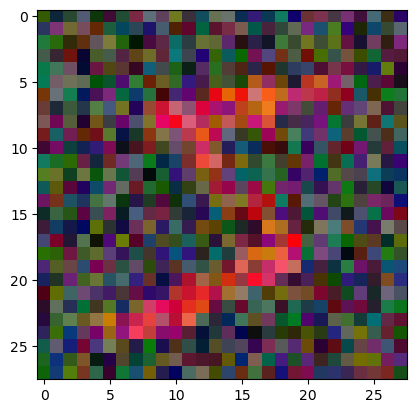

digit: 0 color:green


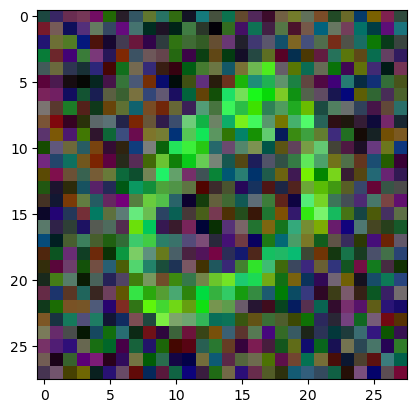

digit: 4 color:red


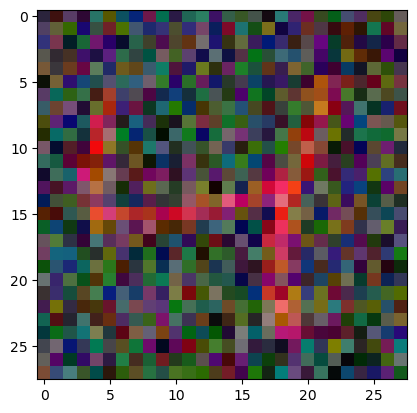

digit: 1 color:green


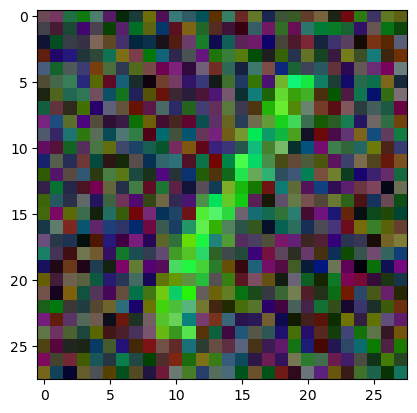

digit: 9 color:red


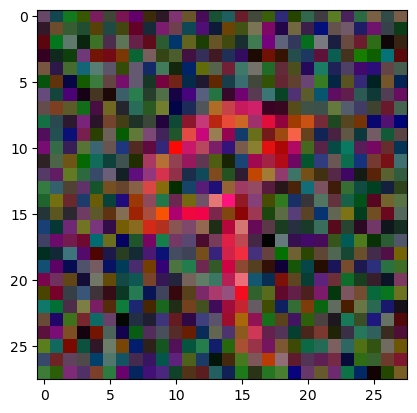

In [4]:
colors = {0:'red', 1:'green'}

for i in range(5):
    x , y,  c = create_exemple(x_train[i],y_train[i])

    print(f'digit: {y} color:{colors[c]}')
    plt.imshow(x)
    plt.show()

## Task 3: Dataset Generator

In [5]:
def generate_data(x,y,batch_size=32):
    num_exemples = len(y)

    while True:
        x_batch = np.zeros((batch_size,28,28,3))
        y_batch = np.zeros((batch_size,))
        c_batch = np.zeros((batch_size,))

        for i in range(0,batch_size):
            index = np.random.randint(0,num_exemples)
            image, digit , color = create_exemple(x[index],y[index])
            x_batch[i] = image
            y_batch[i] = digit
            c_batch[i] = color
        yield x_batch, [y_batch,c_batch]


[9.] [1.]


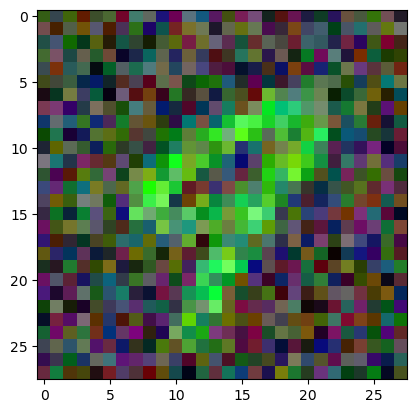

In [6]:
x, [y,c] = next(generate_data(x_test,y_test,batch_size=1))
print(y,c)
plt.imshow(x[0])

## Task 4: Create Model

In [7]:
from tensorflow.keras.layers import Input, Conv2D,Activation, MaxPool2D, Flatten, Add, Dense

input_ = Input(shape=(28,28,3),name = 'Input')
conv_1 = Conv2D(32,3, name='Conv_1')(input_)
act_1 = Activation('relu',name='Activation_1')(conv_1)
pool_1 = MaxPool2D(4,name='Pool_1')(act_1)
flat_1 = Flatten(name='Flatten_1')(pool_1)
#First Output -> predict the color
color = Dense(1,activation='sigmoid',name='color')(flat_1)

conv_2 = Conv2D(32,3,padding='same', name='Conv_2')(act_1)
act_2 = Activation('relu',name='Activation_2')(conv_2)
conv_3 = Conv2D(32,3,padding='same', name='Conv_3')(act_2)
add= Add(name='Add')([act_1,conv_3])
act_3 = Activation('relu',name='Activation_3')(add)
pool_2 = MaxPool2D(4,name='Pool_2')(act_3)
flat_2 = Flatten(name='Flatten_2')(pool_2)

digit = Dense(10,activation='sigmoid',name='digit')(flat_2)

model = tf.keras.models.Model(input_,[digit,color])

model.compile(
    loss = {
        'digit': 'sparse_categorical_crossentropy',
        'color': 'binary_crossentropy'
    },
    optimizer = 'adam',
    metrics = ['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 Conv_1 (Conv2D)                (None, 26, 26, 32)   896         ['Input[0][0]']                  
                                                                                                  
 Activation_1 (Activation)      (None, 26, 26, 32)   0           ['Conv_1[0][0]']                 
                                                                                                  
 Conv_2 (Conv2D)                (None, 26, 26, 32)   9248        ['Activation_1[0][0]']           
                                                                                              

In [8]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Task 5: Training the Model

In [9]:
class Logger(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    digit_accuracy = logs.get('digit_accuracy')
    color_accuracy = logs.get('color_accuracy')
    val_digit_accuracy = logs.get('val_digit_accuracy')
    val_color_accuracy = logs.get('val_color_accuracy')
    print('='*30, epoch + 1, '='*30)
    print(f'digit_accuracy: {digit_accuracy:.2f}, color_accuracy: {color_accuracy:.2f}')
    print(f'val_digit_accuracy: {val_digit_accuracy:.2f}, val_color_accuracy: {val_color_accuracy:.2f}')

In [10]:
train_gen = generate_data(x_train,y_train)
test_gen =  generate_data(x_test,y_test)

_ = model.fit(
    train_gen,
    validation_data = test_gen,
    steps_per_epoch = 200,
    validation_steps = 100,
    epochs = 10,
    callbacks=[
        Logger(),
        tf.keras.callbacks.TensorBoard(log_dir='./logs')
    ],
    verbose=False
)

In [ ]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 12584), started 0:02:26 ago. (Use '!kill 12584' to kill it.)

## Task 6: Final Predictions

In [ ]:
def test_model(show=True):
  x, [y, c] = next(test)

  preds = model.predict(x)
  pred_digit = np.argmax(preds[0])
  pred_color = int(preds[1] > 0.5)
  gt_digit = int(y[0])
  gt_color = int(c[0])

  plt.imshow(x[0])
  if show:
    print(f'GT: {gt_digit}, {colors[gt_color]}')
    print(f'Pr: {pred_digit}, {colors[pred_color]}')
    plt.show()
  else:
    col = 'green' if gt_digit == pred_digit and gt_color == pred_color else 'red'
    plt.ylabel(f'GT: {gt_digit}, {colors[gt_color]}', color=col)
    plt.xlabel(f'Pr: {pred_digit}, {colors[pred_color]}', color=col)
    plt.xticks([])
    plt.yticks([])


test = generate_data(x_test, y_test, batch_size=1)